# demo_run.ipynb 示例

本笔记演示 CellType-GP 的完整流程：载入预处理的空间转录组数据、运行解卷积模型，并与 Xenium 真值打分进行对比评估。

## 1. 环境与路径

若仓库克隆在其他目录，请先更新基础路径。本示例假设工作目录为 `/home/vs_theg/ST_program/CellType_GP`，其中 `DATA` 子目录需要包含 `/home/vs_theg/ST_program/CellType_GP/DATA/spot_data_full.npz` 以及对应真值 CSV。


In [1]:
from pathlib import Path
import pandas as pd

project_root = Path('/home/vs_theg/ST_program/CellType_GP')
package_dir = project_root / 'CellType-GP'
data_dir = project_root / 'DATA'
output_dir = data_dir / 'notebook_outputs'
output_dir.mkdir(exist_ok=True, parents=True)

print(f'Project root: {project_root}')
print(f'Package dir : {package_dir}')
print(f'Data dir    : {data_dir}')

Project root: /home/vs_theg/ST_program/CellType_GP
Package dir : /home/vs_theg/ST_program/CellType_GP/CellType-GP
Data dir    : /home/vs_theg/ST_program/CellType_GP/DATA


## 2. 查看输入矩阵

加载 NPZ 数据包，其中存放 Gene Program 得分 (`visium_score`) 与细胞类型比例 (`spot_cluster_fraction_matrix`)。

In [2]:
import numpy as np
spot_bundle = np.load(data_dir / 'spot_data_full.npz', allow_pickle=True)

Y = spot_bundle['visium_score']            # shape (programs, spots)
X = spot_bundle['spot_cluster_fraction_matrix']  # shape (spots, cell types)
coords = spot_bundle['coords']
spot_names = spot_bundle['spot_names']
celltype_names = spot_bundle['celltype_names']
program_names = spot_bundle['program_names']

print('visium_score shape:', Y.shape)
print('spot_cluster_fraction_matrix shape:', X.shape)
print('coords shape:', coords.shape)
print('First 5 spot IDs:', spot_names[:5])

visium_score shape: (4, 3953)
spot_cluster_fraction_matrix shape: (3953, 7)
coords shape: (3953, 2)
First 5 spot IDs: ['AACACGTGCATCGCAC-1' 'AACACTTGGCAAGGAA-1' 'AACAGGAAGAGCATAG-1'
 'AACAGGATTCATAGTT-1' 'AACAGGTTATTGCACC-1']


## 3. 运行模型

三类解卷积方案可以在 Notebook 中分别触发，每次都会读取 `/home/vs_theg/ST_program/CellType_GP/DATA/spot_data_full.npz` 并写出一份宽表预测 CSV。运行完任意一个方法后即可跳到下一节使用新的评估脚本检查结果。


In [4]:
import sys
sys.path.append(str(package_dir))

from celltype_gp_models import run_model

### 3.1 向量化残差模型

```python
!python /home/vs_theg/ST_program/CellType_GP/celltype_gp_models.py \
    --input /home/vs_theg/ST_program/CellType_GP/DATA/spot_data_full.npz \
    --method vectorized \
    --save /home/vs_theg/ST_program/CellType_GP/DATA/pred_result(vectorized).csv
```

推荐首先运行该基线，用于评估新的 `evaluation.py` 接口。


In [5]:
pred_vectorized_csv = output_dir / 'pred_vectorized.csv'
pred_vectorized_df = run_model(
    npz_path=str(data_dir / 'spot_data_full.npz'),
    method='vectorized',
    save_path=str(pred_vectorized_csv)
)

pred_vectorized_df.head()

/home/vs_theg/ST_program/CellType_GP/CellType-GP/celltype_gp_models.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled = torch.tensor(X_scaled, dtype=torch.float32)
/home/vs_theg/ST_program/CellType_GP/CellType-GP/celltype_gp_models.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y, dtype=torch.float32)


✅ 已保存结果到 /home/vs_theg/ST_program/CellType_GP/DATA/notebook_outputs/pred_vectorized.csv，形状 (3953, 28)


,B_Cells+DCIS_1_score_norm,B_Cells+DCIS_2_score_norm,B_Cells+Prolif_Invasive_score_norm,B_Cells+Invasive_Tumor_score_norm,DCIS+DCIS_1_score_norm,DCIS+DCIS_2_score_norm,DCIS+Prolif_Invasive_score_norm,DCIS+Invasive_Tumor_score_norm,Endothelial+DCIS_1_score_norm,Endothelial+DCIS_2_score_norm,...,Myeloid+Prolif_Invasive_score_norm,Myeloid+Invasive_Tumor_score_norm,Stromal+DCIS_1_score_norm,Stromal+DCIS_2_score_norm,Stromal+Prolif_Invasive_score_norm,Stromal+Invasive_Tumor_score_norm,T_cells+DCIS_1_score_norm,T_cells+DCIS_2_score_norm,T_cells+Prolif_Invasive_score_norm,T_cells+Invasive_Tumor_score_norm
AACACGTGCATCGCAC-1,0.404495,0.479355,0.481217,0.625270,0.373988,0.455953,0.474620,0.623532,0.401281,0.474987,...,0.492315,0.645591,0.315491,0.407248,0.379050,0.532756,0.413590,0.494419,0.484789,0.651556
AACACTTGGCAAGGAA-1,0.678616,0.694938,0.543668,0.689753,0.686968,0.699977,0.543457,0.685649,0.685941,0.705768,...,0.521123,0.660961,0.697520,0.708492,0.564712,0.705379,0.672223,0.684182,0.544147,0.671127
AACAGGAAGAGCATAG-1,0.567071,0.564028,0.618711,0.683600,0.526245,0.524138,0.597246,0.652572,0.553538,0.543172,...,0.628516,0.688964,0.430455,0.443212,0.458120,0.518445,0.565847,0.562604,0.607415,0.680596
AACAGGATTCATAGTT-1,0.429896,0.453296,0.327993,0.661917,0.389069,0.413407,0.306527,0.630890,0.438148,0.465534,...,0.316680,0.644985,0.409302,0.432724,0.302907,0.631631,0.423273,0.442126,0.328996,0.642598
AACAGGTTATTGCACC-1,0.507814,0.410655,0.613459,0.520789,0.466988,0.370765,0.591994,0.489761,0.494281,0.389799,...,0.614625,0.517032,0.383064,0.300091,0.466727,0.369428,0.506590,0.409231,0.602163,0.517785


### 3.2 留一法残差模型

```python
!python /home/vs_theg/ST_program/CellType_GP/celltype_gp_models.py \
    --input /home/vs_theg/ST_program/CellType_GP/DATA/spot_data_full.npz \
    --method delta_loo \
    --save /home/vs_theg/ST_program/CellType_GP/DATA/pred_result(delta_loo).csv
```

该方法更关注泛化能力，可在获得向量化结果后追加运行。


In [6]:
pred_delta_csv = output_dir / 'pred_delta.csv'
pred_delta_df = run_model(
    npz_path=str(data_dir / 'spot_data_full.npz'),
    method='delta',
    save_path=str(pred_delta_csv)
)

pred_delta_df.head()

✅ 已保存结果到 /home/vs_theg/ST_program/CellType_GP/DATA/notebook_outputs/pred_delta.csv，形状 (3953, 28)


,B_Cells+DCIS_1_score_norm,B_Cells+DCIS_2_score_norm,B_Cells+Prolif_Invasive_score_norm,B_Cells+Invasive_Tumor_score_norm,DCIS+DCIS_1_score_norm,DCIS+DCIS_2_score_norm,DCIS+Prolif_Invasive_score_norm,DCIS+Invasive_Tumor_score_norm,Endothelial+DCIS_1_score_norm,Endothelial+DCIS_2_score_norm,...,Myeloid+Prolif_Invasive_score_norm,Myeloid+Invasive_Tumor_score_norm,Stromal+DCIS_1_score_norm,Stromal+DCIS_2_score_norm,Stromal+Prolif_Invasive_score_norm,Stromal+Invasive_Tumor_score_norm,T_cells+DCIS_1_score_norm,T_cells+DCIS_2_score_norm,T_cells+Prolif_Invasive_score_norm,T_cells+Invasive_Tumor_score_norm
AACACGTGCATCGCAC-1,-0.000018,-0.000029,-0.000026,-0.000051,-0.000001,-9.834766e-07,-4.768372e-07,-6.258488e-07,-0.000003,-0.000004,...,-4.172325e-07,-4.470348e-07,-3.039837e-06,-2.592802e-06,-3.516674e-06,-3.397465e-06,2.443790e-06,4.410744e-06,-6.139278e-06,7.212162e-06
AACACTTGGCAAGGAA-1,0.000015,0.000025,0.000022,0.000043,-0.000001,-9.238720e-07,-4.768372e-07,-5.960464e-07,0.000004,0.000005,...,-1.072884e-05,-1.108646e-05,5.960464e-07,5.364418e-07,6.854534e-07,7.152557e-07,-1.519918e-06,-2.682209e-06,3.755093e-06,-4.410744e-06
AACAGGAAGAGCATAG-1,0.000008,0.000013,0.000011,0.000022,-0.000002,-2.205372e-06,-1.072884e-06,-1.400709e-06,-0.000003,-0.000004,...,7.987022e-06,8.225441e-06,-4.500151e-06,-3.784895e-06,-5.185604e-06,-5.066395e-06,1.490116e-07,2.980232e-07,-3.576279e-07,4.768372e-07
AACAGGATTCATAGTT-1,0.000015,0.000025,0.000022,0.000043,-0.000009,-8.314848e-06,-4.023314e-06,-5.185604e-06,0.000005,0.000007,...,-2.205372e-06,-2.264977e-06,-7.748604e-07,-6.556511e-07,-8.940697e-07,-8.940697e-07,-2.235174e-06,-4.112720e-06,5.722046e-06,-6.705523e-06
AACAGGTTATTGCACC-1,0.000009,0.000014,0.000012,0.000024,-0.000002,-2.175570e-06,-1.043081e-06,-1.370907e-06,-0.000003,-0.000005,...,1.609325e-06,1.639128e-06,-4.112720e-06,-3.486872e-06,-4.738569e-06,-4.619360e-06,5.960464e-07,1.102686e-06,-1.490116e-06,1.788139e-06


### 3.3 神经网络学习模型

```python
!python /home/vs_theg/ST_program/CellType_GP/celltype_gp_models.py \
    --input /home/vs_theg/ST_program/CellType_GP/DATA/spot_data_full.npz \
    --method nn \
    --save /home/vs_theg/ST_program/CellType_GP/DATA/train_nn.csv
```

输出的 `train_nn.csv` 可以与其它方法使用同一套评估流程比较。


In [14]:
import subprocess

neural_output = output_dir / 'train_nn.csv'
script_path = package_dir / 'celltype_gp_deconvolution.py'
result = subprocess.run(['python', str(script_path)], check=False)
if result.returncode != 0:
    print('神经网络脚本执行失败，返回码:', result.returncode)
else:
    train_path = data_dir / 'train1500_result(wide).csv'
    if train_path.exists():
        df_train = pd.read_csv(train_path, index_col=0)
        df_train.to_csv(neural_output)
        print('神经网络结果已复制到:', neural_output)
    else:
        print('未找到神经网络输出文件:', train_path)

neural_output

✅ 已设置随机种子: 42
Y (shape: torch.Size([4, 3953])):
tensor([[0.2402, 0.6843, 0.3749, 0.3554, 0.3215],
        [0.3340, 0.7076, 0.3947, 0.3947, 0.2463],
        [0.2931, 0.5023, 0.4006, 0.2308, 0.4006],
        [0.4453, 0.6311, 0.4746, 0.5413, 0.3165]])

X (shape: torch.Size([3953, 7])):
tensor([[0.0714, 0.0000, 0.0000, 0.0000, 0.0714],
        [0.0000, 0.1064, 0.2128, 0.0000, 0.1702],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2222, 0.0000, 0.1111],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0455]])

coords (shape: (3953, 2)):
[[13355 16640]
 [ 8845 12067]
 [14716 15518]
 [11404 12365]
 [ 7452  9059]]
Epoch 0, Loss=96.7774, Recon=0.1043
Epoch 100, Loss=52.1868, Recon=0.0822
Epoch 200, Loss=28.3820, Recon=0.0697
Epoch 300, Loss=15.9459, Recon=0.0628
Epoch 400, Loss=9.6346, Recon=0.0591
Epoch 500, Loss=6.5136, Recon=0.0573
Epoch 600, Loss=4.9799, Recon=0.0565
Epoch 700, Loss=4.1966, Recon=0.0563
Epoch 800, Loss=3.7489, Recon=0.0566
Epoch 900, Loss=3.4413, Re

PosixPath('/home/vs_theg/ST_program/CellType_GP/DATA/notebook_outputs/train_nn.csv')

## 4. 拟合度评估：单方法逐次对比

`evaluation.py` 已重写为逐方法评估脚本，可直接在 Notebook 中导入函数，计算非缺失 spot 的 Pearson/Spearman、MAE、RMSE，并生成散点图。

```python
import sys
from pathlib import Path

project_root = Path('/home/vs_theg/ST_program/CellType_GP/CellType-GP')
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from evaluation import (
    load_tables, compute_regression_metrics, compute_presence_metrics, plot_regression_scatter
)

truth_path = Path('/home/vs_theg/ST_program/CellType_GP/DATA/truth_output/truth_result(wide).csv')
pred_path = Path('/home/vs_theg/ST_program/CellType_GP/DATA/pred_result(vectorized).csv')

truth, pred = load_tables(truth_path, pred_path)
reg_summary, reg_details = compute_regression_metrics(truth, pred)
reg_summary

merged_data = truth.stack().rename('truth').to_frame().join(
    pred.stack().rename('pred'), how='inner'
).dropna()
plot_regression_scatter(merged_data, method_name='vectorized', output=None, show=True)
```

重复替换 `pred_path` 与 `method_name` 即可评估其它解卷积结果。若希望批量保存指标，请参考下一节的 CLI 用法。


In [15]:
from evaluation import evaluate_deconvolution_enhanced

truth_wide = pd.read_csv(data_dir / 'truth_output' / 'truth_result(wide).csv', index_col=0)
metrics_dir = output_dir / 'metrics'
metrics_dir.mkdir(exist_ok=True, parents=True)

method_specs = {
    '向量化残差模型': {'path': output_dir / 'pred_vectorized.csv', 'slug': 'vectorized'},
    '留一法残差模型': {'path': output_dir / 'pred_delta.csv', 'slug': 'delta'},
    '神经网络模型': {'path': output_dir / 'train_nn.csv', 'slug': 'neural'},
}

metrics_results = {}
pred_tables = {}
summary_rows = []

for label, spec in method_specs.items():
    csv_path = spec['path']
    slug = spec['slug']
    pred_table = pd.read_csv(csv_path, index_col=0)
    pred_tables[label] = pred_table
    metrics_df = evaluate_deconvolution_enhanced(
        truth_wide=truth_wide,
        pred_wide=pred_table,
        verbose=False,
        compute_prob_metrics=False
    )
    metrics_results[label] = metrics_df
    metrics_file = metrics_dir / f"{slug}_metrics.csv"
    metrics_df.to_csv(metrics_file, index=False)
    summary_rows.append({
        '方法': label,
        '平均 PearsonR': metrics_df['PearsonR'].mean(skipna=True),
        '平均 F1': metrics_df['F1'].mean(skipna=True),
        '指标文件': metrics_file.name
    })

summary_df = pd.DataFrame(summary_rows)
summary_path = metrics_dir / 'metrics_summary.csv'
summary_df.to_csv(summary_path, index=False)
summary_df

,方法,平均 PearsonR,平均 F1,指标文件
0,向量化残差模型,0.222538,0.620829,vectorized_metrics.csv
1,留一法残差模型,0.123398,0.542854,delta_metrics.csv
2,神经网络模型,0.027150,0.621395,neural_metrics.csv


## 5. 存在性（二分类）分析

调用同一套函数即可得到存在性评估，涵盖精确率、召回率、F1、准确率，以及在安装 `scikit-learn` 时的 `roc_auc` 与 `average_precision`。

```python
presence_summary, presence_details = compute_presence_metrics(truth, pred, threshold=0.05)
presence_summary
```

根据任务需要调整 `threshold`，以平衡漏检与误检。若要导出完整 CSV，可在 Notebook 中运行：

```python
!python /home/vs_theg/ST_program/CellType_GP/CellType-GP/evaluation.py \
    --truth /home/vs_theg/ST_program/CellType_GP/DATA/truth_output/truth_result(wide).csv \
    --prediction /home/vs_theg/ST_program/CellType_GP/DATA/pred_result(vectorized).csv \
    --method-name vectorized \
    --presence-threshold 0.05 \
    --per-feature-regression /home/vs_theg/ST_program/CellType_GP/DATA/eval/vectorized_regression.csv \
    --per-feature-presence /home/vs_theg/ST_program/CellType_GP/DATA/eval/vectorized_presence.csv
```


✅ 共 28 个特征，spots=3953
低覆盖 (<5) 特征: 0
✅ 共 28 个特征，spots=3953
低覆盖 (<5) 特征: 0
✅ 共 21 个特征，spots=3953
低覆盖 (<5) 特征: 0


/tmp/ipykernel_3799825/3340111273.py:14: UserWarning: Glyph 21521 (\N{CJK UNIFIED IDEOGRAPH-5411}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3799825/3340111273.py:14: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3799825/3340111273.py:14: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3799825/3340111273.py:14: UserWarning: Glyph 27531 (\N{CJK UNIFIED IDEOGRAPH-6B8B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3799825/3340111273.py:14: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3799825/3340111273.py:14: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3799825/3340111273.py:14: UserWarning: Glyph 22411 (\N{CJK UN

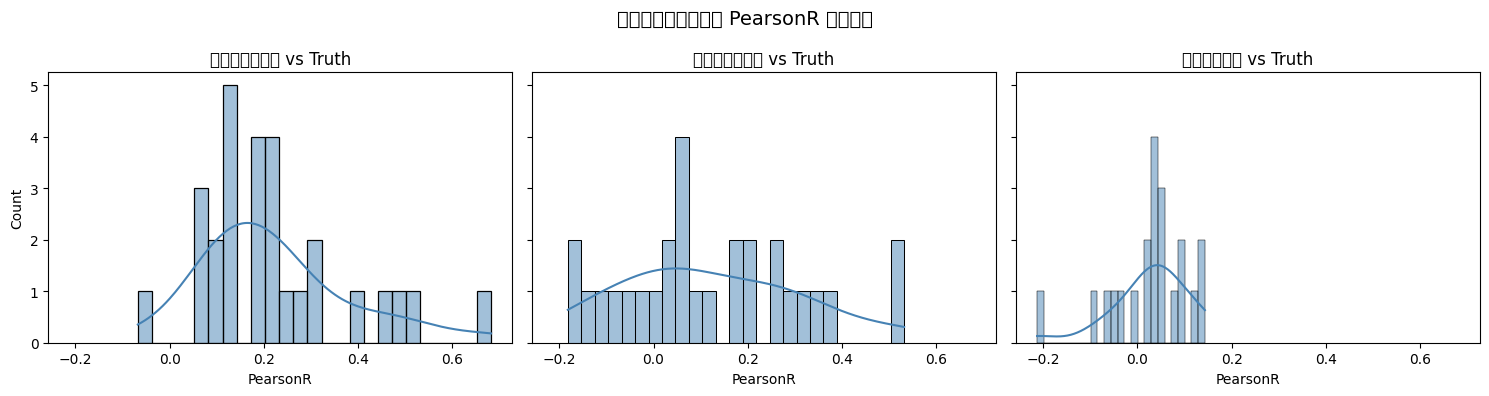

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

for ax, (label, pred_table) in zip(axes, pred_tables.items()):
    evaluate_deconvolution_enhanced(
        truth_wide=truth_wide,
        pred_wide=pred_table,
        verbose=True,
        compute_prob_metrics=False,
        ax=ax,
        plot_title=f'{label} vs Truth'
    )

fig.suptitle('反卷积方法与真值的 PearsonR 分布对比', fontsize=14)
plt.tight_layout()
plt.show()

## 6. 可选：重新计算基因程序得分

若需重新生成打分矩阵，可运行预处理脚本。该步骤依赖 Scanpy、Squidpy 及图形后端；使用前请按需取消注释。

In [ ]:
# from preprocessing import score_gene_programs  # heavy Scanpy dependencies
# import scanpy as sc

# adata_x = sc.read(data_dir / 'xdata.h5')

# # gene_sets_to_score is defined inside preprocessing.py; import if needed
# from preprocessing import gene_sets_to_score
# score_gene_programs(adata_x, gene_sets_to_score, platform='xenium', output_dir=data_dir / 'xenium_scores')
# adata_x.write(data_dir / 'xdata_processed.h5')

## 7. 可选：神经网络解卷积基线

脚本 `celltype_gp_deconvolution.py` 提供基于拉普拉斯正则的替代模型，可独立运行以训练并保存 `Y_tps_result.csv`。

```bash
python /home/vs_theg/ST_program/CellType_GP/CellType-GP/celltype_gp_deconvolution.py
```
